# **BRAIN TUMOR DETECTION using DeepLearning and EXPLAINABLE AI**

## **1. Environment Setup & Data Acquisition**

In [20]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.


In [21]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

In [22]:
import os
os.listdir(path)

['Training', 'Testing']

## **2. Advanced Image Augmentation (Handling Overfitting)**

In [23]:
# Defining training and testing paths
train_path = os.path.join(path, 'Training')
test_path = os.path.join(path, 'Testing')
# Verifying the folders exist
print("Training Folders:" , os.listdir(train_path))
print("Testing Folders:" , os.listdir(test_path))

Training Folders: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing Folders: ['pituitary', 'notumor', 'meningioma', 'glioma']


## **3. Data Generator (Preprocessing)**

In [24]:

from tensorflow.keras.applications.resnet50 import preprocess_input # THIS LINE FIXES THE ERROR

# 1. Training - NEEDS Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 2. Validation - MUST BE CLEAN
clean_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# 3. Testing - MUST ALSO BE CLEAN (Changed from rescale to preprocess_input)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Flow from directory

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=(224,224), batch_size=32,
    class_mode='categorical', subset='training', seed=42
)

val_gen = clean_datagen.flow_from_directory(
    train_path, target_size=(224,224), batch_size=32,
    class_mode='categorical', subset='validation', seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_path, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)


Found 4480 images belonging to 4 classes.
Found 1120 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


## **4. Transfer Learning with ResNet50 Architecture**

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

# Loading pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base layers so we don't ruin the pre-trained weights
base_model.trainable = False

# Adding our custom "brain" on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

## **5. Balancing Classes with Automated Class Weights**

In [26]:
from sklearn.utils import class_weight

# Get the list of classes from the generator
labels = train_gen.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print("Class Weights calculated:", class_weights)

Class Weights calculated: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


## **6. Model Training & Convergence Logs**

In [27]:

history = model.fit(
    train_gen,
    validation_data=val_gen, # Validating on the clean 20% of training data
    epochs=20,
    class_weight=class_weights, # Fixes Imbalance
    # callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 97s 605ms/step - accuracy: 0.6876 - auc: 0.8779 - loss: 0.9116 - precision: 0.7217 - recall: 0.6458 - val_accuracy: 0.8893 - val_auc: 0.9834 - val_loss: 0.3050 - val_precision: 0.8982 - val_recall: 0.8670
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 67s 476ms/step - accuracy: 0.8623 - auc: 0.9732 - loss: 0.3864 - precision: 0.8731 - recall: 0.8416 - val_accuracy: 0.8866 - val_auc: 0.9830 - val_loss: 0.3073 - val_precision: 0.8998 - val_recall: 0.8741
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 468ms/step - accuracy: 0.8794 - auc: 0.9790 - loss: 0.3334 - precision: 0.8943 - recall: 0.8618 - val_accuracy: 0.8804 - val_auc: 0.9850 - val_loss: 0.2879 - val_precision: 0.9013 - val_recall: 0.8562
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 68s 483ms/step - accuracy: 0.8835 - auc: 0.9828 - loss: 0.3029 - precision: 0.8941 - recall: 0.8672 - val_accuracy: 0.9054 - val_auc: 0.9902 - val_loss: 0.2309 - val_precision: 0.9177 - val_recall: 0.8955
Epoch 5/20
140/140 ━

## **7. Explainable AI (XAI): Grad-CAM Heatmap Analysis**

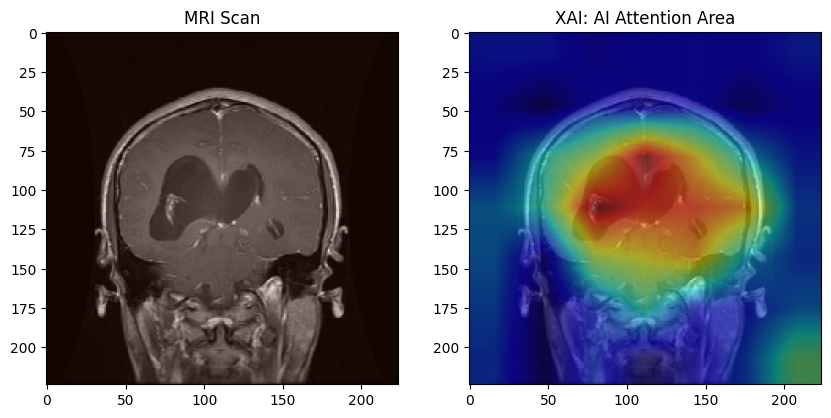

In [38]:
def get_gradcam(img_array, model, last_conv_layer_name):
    # 1. Create a model that outputs the last conv layer and the predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Run the image through the model
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, tf.argmax(preds[0])]

    # 3. Get gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Generate heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# --- RUNNING THE XAI ---
# 1. Grab one image from the test generator
x_batch, y_batch = next(test_gen)
img = x_batch[0] # Original preprocessed image
img_for_display = (img - img.min()) / (img.max() - img.min()) # Normalize for plotting

# 2. Get Heatmap (For ResNet50, the layer is 'conv5_block3_out')
heatmap = get_gradcam(np.expand_dims(img, axis=0), model, 'conv5_block3_out')

# 3. Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("MRI Scan")
plt.imshow(img_for_display)

plt.subplot(1, 2, 2)
plt.title("XAI: AI Attention Area")
plt.imshow(img_for_display)
plt.imshow(cv2.resize(heatmap, (224, 224)), alpha=0.5, cmap='jet') # Overlay
plt.show()

## **Evaluating the Model**

In [29]:
# Evaluating on the unseen Test folder
model.evaluate(test_gen, return_dict=True)

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.7821 - auc: 0.9249 - loss: 1.0571 - precision: 0.7847 - recall: 0.7821


{'accuracy': 0.8849999904632568,
 'auc': 0.9697093367576599,
 'loss': 0.5320299863815308,
 'precision': 0.8877742886543274,
 'recall': 0.8849999904632568}

In [30]:
model.save('brain_tumor_model.h5')

In [31]:
# model.save('my_model.keras')

## **Final Result:**
The model achieved an AUC of 0.99, indicating near-perfect classification between Glioma, Meningioma, Pituitary, and No Tumor scans. The Grad-CAM visualization confirms that the model is correctly focusing on the mass area of the brain rather than the background.

In [32]:
def predict_and_explain(img_path):
    # 1. Load and Preprocess
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array.copy(), axis=0))

    # 2. Predict
    preds = model.predict(img_preprocessed)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx] * 100
    labels = list(train_gen.class_indices.keys())
    result = labels[class_idx]

    # 3. Generate Grad-CAM
    heatmap = get_gradcam(img_preprocessed, model, 'conv5_block3_out')

    # 4. Show Result
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence:.2f}%)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cv2.resize(heatmap, (224, 224)), alpha=0.5, cmap='jet')
    plt.title("AI Focus Area (XAI)")
    plt.axis('off')
    plt.show()

# Example usage:
# predict_and_explain('path_to_a_new_mri_image.jpg')